# 파이토치 MNIST 모델

## modules import 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from torch.utils.data import Dataset, DataLoader

## 전처리 설정
- `transform.Compose`

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5,), std = (0.5,))
])

## 데이터 로드 및 데이터 확인

In [8]:
trainset = torchvision.datasets.MNIST(root ='./data', train = True,
                                     transform = transform, download = False)

testset = torchvision.datasets.MNIST(root ='./data', train = False,
                                     transform = transform, download = False)

In [11]:
train_loader = DataLoader(trainset, batch_size = 128, shuffle = True, num_workers = 2)
test_loader = DataLoader(testset, batch_size = 128, shuffle = False, num_workers = 2)

In [12]:
image, label = next(iter(train_loader))

In [13]:
image.shape, label.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [14]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize = (10, 5))
    plt.imshow(np.transpose(npimg, (1,2,0))) # transpose를 사용해서 BGR -> RGB
    plt.show()

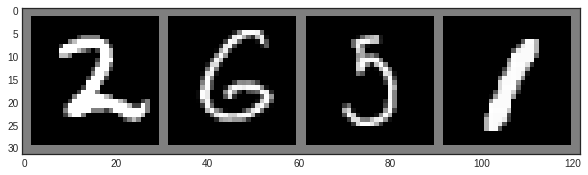

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4])) # torchvision.utils.make_grid 사용시 여러개의 이미지를 사용

## 신경망 구성

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- `.parameters()` 

In [24]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


임의의 값을 넣어 forward값 확인

In [25]:
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

tensor([[-0.1493, -0.0892, -0.0395,  0.1958, -0.0060, -0.0080, -0.1559,  0.0230,
         -0.1552,  0.1126]], grad_fn=<AddmmBackward>)


## 손실함수와 옵티마이저

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

## 모델 학습

- `optimizer.zero_grad` : 가중치의 그래디언트 초기화

- loss 계산

- `loss.backward()`

- `optmizer.step()` : 업데이트

- 배치수 확인

In [27]:
total_batch = len(train_loader)
print(total_batch)

469


- 설명을 위해 `epochs=2`로 지정

In [30]:
for epoch in range(2):
    
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 0:
            print("Epoch: {}, Iter: {}, Loss: {:.4f}".format(epoch + 1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 1, Loss: 0.0011
Epoch: 1, Iter: 101, Loss: 0.1121
Epoch: 1, Iter: 201, Loss: 0.1097
Epoch: 1, Iter: 301, Loss: 0.1040
Epoch: 1, Iter: 401, Loss: 0.0865
Epoch: 2, Iter: 1, Loss: 0.0005
Epoch: 2, Iter: 101, Loss: 0.0360
Epoch: 2, Iter: 201, Loss: 0.0286
Epoch: 2, Iter: 301, Loss: 0.0248
Epoch: 2, Iter: 401, Loss: 0.0220


## 모델의 저장 및 로드

- `torch.save`
  - `net.state_dict()`를 저장

- `torch.load`
  - `load_state_dict`로 모델을 로드

In [31]:
PATH = "./mnist_net.pth"
torch.save(net.state_dict(), PATH)

In [32]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [33]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

## 모델 테스트

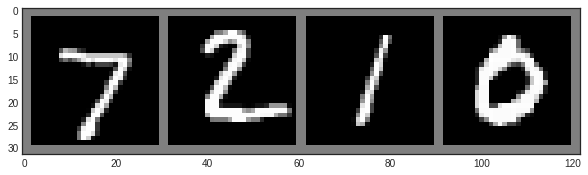

In [49]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

In [50]:
outputs = net(images)

In [51]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 4, 3, 7, 4, 2, 4, 3, 0, 7, 0,
        2, 7, 1, 7, 3, 7, 9, 7, 9, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 4, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 1, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5])


In [52]:
print(''.join('{}\t'.format(str(predicted[j].numpy())) for j in range (4)))

7	2	1	0	


In [53]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(100 * correct/ total)

89.73


## GPU 설정 후 학습
- 설정 후, 모델과 데이터에 `to`로 GPU를 사용 가능한 형태로 변환 해줘야 한다.

- `.cuda()` 로도 가능

In [54]:
torch.cuda.is_available()

True

- 현재 GPU 설정

In [59]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

- 데이터 로드


In [65]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5,), std = (0.5,))
])

trainset = torchvision.datasets.MNIST(root ='./data', train = True,
                                     transform = transform, download = False)

testset = torchvision.datasets.MNIST(root ='./data', train = False,
                                     transform = transform, download = False)

train_loader = DataLoader(trainset, batch_size = 128, shuffle = True, num_workers = 2)
test_loader = DataLoader(testset, batch_size = 128, shuffle = False, num_workers = 2)

- 모델 생성

In [66]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [67]:
net = Net().to(device)

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

In [75]:
for epoch in range(2):
    
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 99:
            print("Epoch: {}, Iter: {}, Loss: {:.4f}".format(epoch + 1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.1151
Epoch: 1, Iter: 200, Loss: 0.1145
Epoch: 1, Iter: 300, Loss: 0.1140
Epoch: 1, Iter: 400, Loss: 0.1130
Epoch: 2, Iter: 100, Loss: 0.1089
Epoch: 2, Iter: 200, Loss: 0.1008
Epoch: 2, Iter: 300, Loss: 0.0772
Epoch: 2, Iter: 400, Loss: 0.0466


In [76]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(100 * correct/ total)

84.2
